# Installation

Install the necessary modules that are going to be used in the notebook.

In [ ]:
%%capture
!pip install -U scikit-learn tensorflow-addons tf-models-official
# !pip install --upgrade tfds-nightly
!pip install dropbox
!pip install nlpaug transformers

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow_probability as tfpd
import tensorflow_addons as tfa
import tensorflow_hub as hub
import dropbox
import pickle

from tensorflow.keras import applications as apps
from tensorflow.keras import layers, optimizers, metrics, utils

from IPython.display import display
from os import path
from google.colab import files
from pathlib import Path
from time import time
from functools import reduce
from shutil import make_archive, unpack_archive, rmtree
from tqdm import tqdm

In [ ]:
# try:
#   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#   print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
# except ValueError:
#   raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# strategy = tf.distribute.TPUStrategy(tpu)

# Dataset creation and visualization

We use the *ag_news_subset* to demonstrate the sample efficiency improvements for text datasets. Tensorflow makes it available through *tensorflow_datasets* package. Details about the dataset are available at: [AG News Dataset](https://www.tensorflow.org/datasets/catalog/ag_news_subset)

The AG's news topic classification dataset is constructed by choosing 4 largest classes from the original corpus. Each class contains 30,000 training samples and 1,900 testing samples. The total number of training samples is 120,000 and testing 7,600.

| Name     | Id       |
| -------- | :------: |
| World    | 0        |
| Sports   | 1        |
| Business | 2        |
| Sci/Tech | 3        |

In this section, we will create the training, validation and the test splits for the dataset. The dataset elements are formatted as a tuple *(text, class_label)*. We expose the following objects:
* train_ds (Training dataset)
* test_ds (Test dataset)
* ds_info (Dataset metadata object)

* [Colab Tutorial](https://colab.research.google.com/github/dlmacedo/starter-academic/blob/master/content/courses/deeplearning/notebooks/tensorflow/fine_tuning_bert.ipynb#scrollTo=idxyhmrCQcw5)
* [Kaggle Tutorial](https://www.kaggle.com/au1206/fine-tuning-bert-text-classification)

In [ ]:
DATASET_SPLITS = ['train[:60%]', 'train[60%:]', 'test']
NUM_CLASSES = 2 #ds_info.features['label'].num_classes

In [ ]:
%%capture
(train_ds, val_ds, test_ds), ds_info = tfds.load(
  name='imdb_reviews', 
  split=DATASET_SPLITS,
  as_supervised=True,
  with_info=True
)

In [ ]:
next(train_ds.as_numpy_iterator()), ds_info

((b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
  0),
 tfds.core.DatasetInfo(
     name='imdb_reviews',
     version=1.0.0,
     description='Large Movie Review Dataset.
 This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly pola

## Apply preliminary transformations to the datasets.

These are the transformations that apply to all the splits of the dataset like data cleaning or formatting.

In [ ]:
# !pip install -U gensim
# !pip install spacy[cuda111]
# import spacy
# spacy.prefer_gpu()
# !nvcc --version

In [ ]:
# import gensim.downloader as api

# info = api.info()  # show info about available models/datasets
# model = api.load("glove-twitter-25")  # download the model and return as object ready for use
# model.get_vector('hello')

In [ ]:
!python -m spacy download en_core_web_md

     |████████████████████████████████| 96.4 MB 1.3 MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.5-py3-none-any.whl size=98051302 sha256=40544cf782ce8508437120a5e166b55a489d94365426616d1ecf62f073a396ad
  Stored in directory: /tmp/pip-ephem-wheel-cache-7krwubyc/wheels/69/c5/b8/4f1c029d89238734311b3269762ab2ee325a42da2ce8edb997
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [ ]:
import en_core_web_md
nlp = en_core_web_md.load()

In [ ]:
np.zeros(shape=(10))

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
MAX_SEQ_LEN = 500
WORD2VEC_LEN = 300

def vectorizepyfn(text):
  text = text.numpy().decode('utf-8')
  doc = nlp(text)
  text_vectors = np.array(list(map(lambda word: word.vector, doc))[:MAX_SEQ_LEN])
  num_text_vectors = len(text_vectors)
  padding = np.zeros(shape=(MAX_SEQ_LEN - num_text_vectors, WORD2VEC_LEN)) if num_text_vectors < MAX_SEQ_LEN else None
  vector = np.concatenate((text_vectors, padding)) if padding is not None else np.array(text_vectors)

  return vector

def vectorizefn(text, label):
  vector = tf.py_function(vectorizepyfn, inp=[text], Tout=tf.float32)
  vector.set_shape((None, WORD2VEC_LEN))
  return vector, label

In [ ]:
def mapchainfn(ds, funcs=[], cache=False):
  result_ds = reduce(lambda y,x: y.map(x), funcs, ds)
  return result_ds.cache() if cache else result_ds

In [ ]:
train_prep_ds = mapchainfn(train_ds.take(500))
val_prep_ds = mapchainfn(val_ds)
test_prep_ds = mapchainfn(test_ds)
# itr = train_prep_ds.map(vectorizefn)
# next(itr)

## Dataset visualization

In [ ]:
def ds_show(ds, info=None, count=10, title='dataset'):
  df = pd.DataFrame(ds.take(count), columns=info.supervised_keys if info else [])
  return df
  #return display(tfds.as_dataframe(ds.take(count), info))

print(ds_show(train_ds, ds_info))

                                                text                                label
0  tf.Tensor(b"This was an absolutely terrible mo...  tf.Tensor(0, shape=(), dtype=int64)
1  tf.Tensor(b'I have been known to fall asleep d...  tf.Tensor(0, shape=(), dtype=int64)
2  tf.Tensor(b'Mann photographs the Alberta Rocky...  tf.Tensor(0, shape=(), dtype=int64)
3  tf.Tensor(b'This is the kind of film for a sno...  tf.Tensor(1, shape=(), dtype=int64)
4  tf.Tensor(b'As others have mentioned, all the ...  tf.Tensor(1, shape=(), dtype=int64)
5  tf.Tensor(b"This is a film which should be see...  tf.Tensor(1, shape=(), dtype=int64)
6  tf.Tensor(b'Okay, you have:<br /><br />Penelop...  tf.Tensor(0, shape=(), dtype=int64)
7  tf.Tensor(b'The film is based on a genuine 195...  tf.Tensor(0, shape=(), dtype=int64)
8  tf.Tensor(b'I really love the sexy action and ...  tf.Tensor(0, shape=(), dtype=int64)
9  tf.Tensor(b'Sure, this one isn\'t really a blo...  tf.Tensor(0, shape=(), dtype=int64)


## Metrics visualization

In [ ]:
def plot_metric(history, metric='accuracy', val=True):
  val_metric = 'val_' + metric

  # Plot training and validation metrics
  plt.plot(history.history[metric])
  plt.plot(history.history[val_metric]) if val else None

  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'] if val else ['train'], loc='upper left')
  plt.show()

# Initialize the datastore

We store our run data in a dropbox store. Key Variables:

* **PROJECT**: Location of the store.
* **UPLOAD_FREQUENCY**: Checkpoint upload frequency.


In [ ]:
PROJECT = 'sample_efficiency_text_word2vec'
CHKPT_DIR = Path('chkpt')
CHKPT_TMPL = Path(CHKPT_DIR, 'epoch-{epoch:d}-val_accuracy-{val_accuracy:.4f}/weights')
HISTORY_DIR = Path('hist')
INITIAL_WEIGHTS = Path('initial_weights/weights')
UPLOAD_FREQUENCY = 20

In [ ]:
DBX = dropbox.Dropbox('')
CHUNK_SIZE = 20 * 1024 * 1024

def dbx_upload_large_file(local_path, remote_path, mode=None):
  size = local_path.stat().st_size
  with open(local_path, "rb") as f, tqdm(total=size, desc="Uploaded") as pbar:
    session_start = DBX.files_upload_session_start(f.read(CHUNK_SIZE))
    pbar.update(CHUNK_SIZE)
    
    cursor = dropbox.files.UploadSessionCursor(session_id=session_start.session_id, offset=f.tell())
    while f.tell() < size:
      if (size - f.tell()) <= CHUNK_SIZE:
        commit = dropbox.files.CommitInfo(path=remote_path, mode=mode)
        DBX.files_upload_session_finish(f.read(CHUNK_SIZE), cursor, commit)
      else:
        DBX.files_upload_session_append_v2(f.read(CHUNK_SIZE), cursor)
        cursor.offset = f.tell()
      
      pbar.update(CHUNK_SIZE)

def dbx_download(local_path, remote_path):
  DBX.files_download_to_file(local_path, remote_path)
  return local_path

def dbx_upload(local_path, remote_path, overwrite=False):
  mode = dropbox.files.WriteMode.overwrite if overwrite else None
  
  if local_path.stat().st_size <= CHUNK_SIZE:
    # Upload Small File
    with open(local_path, "rb") as f: DBX.files_upload(f.read(), remote_path, mode=mode)
  else:
    dbx_upload_large_file(local_path, remote_path, mode)
    
  return remote_path

def dbx_latest_filter(item):
  return item.server_modified

def dbx_latest_history(experiment):
  hist_path = Path('/', PROJECT, experiment, HISTORY_DIR)
  info = DBX.files_list_folder(str(hist_path))
  latest = max(info.entries, key=dbx_latest_filter) # Latest entry
  local_path = HISTORY_DIR / latest.name if latest else None # Local path
  remote_path = latest.path_display if latest else None

  return str(local_path), remote_path

def dbx_latest_chkpt(experiment):
  chkpt_path = path.join('/', PROJECT, experiment, CHKPT_DIR)
  info = DBX.files_list_folder(chkpt_path)
  latest = max(info.entries, key=dbx_latest_filter) # Latest entry
  local_path = path.join(CHKPT_DIR, latest.name) if latest else None # Local path
  remote_path = latest.path_display if latest else None

  return local_path, remote_path

def latest_local_chkpt():
  checkpoints = Path(CHKPT_DIR).glob('**/*.index')
  latest = max(checkpoints, key=path.getctime) if checkpoints else None
  return latest.parent

def latest_local_hist():
  histories = HISTORY_DIR.glob('*.hist')
  latest = max(histories, key=path.getctime) if histories else None
  return latest

def dbx_exp_download(experiment, filepath):
  remote_path = path.join('/', PROJECT, experiment, filepath)
  dbx_download(filepath, remote_path)
  return filepath

def dbx_exp_upload(experiment, filepath):
  remote_path = path.join('/', PROJECT, experiment, filepath)
  dbx_upload(filepath, remote_path)
  return filepath

def dbx_download_chkpt(experiment):
  info = dbx_latest_chkpt(experiment)
  return dbx_download(*info)

def dbx_upload_chkpt(experiment, overwrite=False):
  checkpoint = latest_local_chkpt()
  zip_path = Path(make_archive(str(checkpoint), 'zip', str(checkpoint))) # Create temporary archive
  
  zip_name = zippath(checkpoint) # Upload file name
  remote_path = Path('/', PROJECT, experiment, zip_name) # Construct remote path
  dbx_upload(zip_path, str(remote_path), overwrite) # Upload file

  Path(zip_path).unlink() # Clean up temporary archive

  return remote_path

def dbx_upload_history(experiment):
  hist_name = latest_local_hist()
  remote_path = Path('/', PROJECT, experiment, hist_name)
  return dbx_upload(hist_name, str(remote_path))

def dbx_download_history(experiment):
  info = dbx_latest_history(experiment)
  return dbx_download(*info)

def zippath(p):
  return p.parent / f'{p.name}.zip'

def dbx_download_initial_weights():
  weight_zip = zippath(INITIAL_WEIGHTS.parent)
  remote_path = path.join('/', PROJECT, weight_zip.name)

  zip_path = dbx_download(weight_zip.name, remote_path) # Download archive
  unpack_archive(zip_path, str(INITIAL_WEIGHTS.parent)) # Unzip contents
  Path(zip_path).unlink() # Clean up the archive

def dbx_upload_initial_weights(overwrite=False):
  weight_dir = INITIAL_WEIGHTS.parent.name
  zip_path = Path(make_archive(weight_dir, 'zip', weight_dir))

  remote_path = path.join('/', PROJECT, zip_path.name)
  return dbx_upload(zip_path, remote_path, overwrite)

Path(CHKPT_DIR).mkdir(parents=True, exist_ok=True)
HISTORY_DIR.mkdir(parents=True, exist_ok=True)

In [ ]:
def dbx_history(experiment):
  hist_file = dbx_download_history(experiment)
  hist = pickle.load(open(hist_file, "rb"))
  
  return hist

def history_tmpl():
  snapshot_time = int(time())
  return 'history-{0}.hist'.format(snapshot_time)

def save_history(history):
  hist_name = history_tmpl()
  hist_path = HISTORY_DIR / hist_name

  pickle.dump(history.history, open(hist_path, "wb"))
  return str(hist_path)

# Model architecture

We use a double stacked bidirectional LSTM model to classify AGNews dataset. The model is exposed through a **model** variable. 

In [ ]:
from dropbox.exceptions import ApiError

def save_and_upload_model(m, overwrite=False):
  m.save_weights(str(INITIAL_WEIGHTS))
  print('Uploading initial_weights to remote...')
  dbx_upload_initial_weights(overwrite)

def configure_initial_weights(m, overwrite=False):
  # Download Project Weights
  if not INITIAL_WEIGHTS.parent.exists():
    try:
      print('Downloading remote initial weights...')
      dbx_download_initial_weights()
      print('Download complete!')
    except ApiError:
      print('Remote initial weights are unavailable')

  if INITIAL_WEIGHTS.parent.exists():
    print('Loading initial_weights...')
    try:
      m.load_weights(str(INITIAL_WEIGHTS))
    except ValueError:
      try:
        print('Available weights are incompatible with the model. They will be updated.')
        save_and_upload_model(m, overwrite)
      except:
        rmtree(INITIAL_WEIGHTS.parent)
        raise EnvironmentError('Load failed. Please enable overwrite.')
  else:
    save_and_upload_model(m, overwrite)

In [ ]:
LEARNING_RATE = 0.0002

In [ ]:
# # HUB_LAYER_URL = "https://tfhub.dev/google/nnlm-en-dim50/2"
# HUB_LAYER_URL = 'https://tfhub.dev/google/universal-sentence-encoder/4'

# def get_hub_layer():
#   hl = hub.KerasLayer(HUB_LAYER_URL, input_shape=[], dtype=tf.string, trainable=True)
#   return hl

# def create_model():
#   model = tf.keras.Sequential([
#     get_hub_layer(),
#     layers.Dense(16, activation='relu'),
#     layers.Dense(1, activation='sigmoid')
#   ])

#   adam = optimizers.Adam(learning_rate=LEARNING_RATE)

#   model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

#   return model

# model = create_model()
# model.summary()

In [ ]:
def create_model():
  model = tf.keras.Sequential([
    layers.Bidirectional(layers.LSTM(64, return_sequences=True), input_shape=(MAX_SEQ_LEN, WORD2VEC_LEN)),
    layers.Dropout(0.5),
    layers.Bidirectional(layers.LSTM(32, return_sequences=False)),
	  layers.Dropout(0.5),
    layers.Dense(20, activation='relu'),
    layers.Flatten(),
    layers.Dense(1, activation='sigmoid'),
  ])
  adam = optimizers.Adam(learning_rate=LEARNING_RATE)

  model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

  return model

model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 500, 128)          186880    
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 128)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                41216     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1300      
_________________________________________________________________
flatten (Flatten)            (None, 20)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [ ]:
# text, label = next(iter(train_prep_ds))
# model(tf.expand_dims(text, axis=0))

# Training functions

In [ ]:
from tensorflow.keras.callbacks import LambdaCallback

def checkpoint_uploadfn(name):
  upload_path = dbx_upload_chkpt(name)
  #print('Uploaded: ' + upload_path)

def get_upload_callback(name, epochs=20):
  on_epoch_end = lambda epoch, logs: checkpoint_uploadfn(name) if (epoch + 1) % epochs == 0 else None
  on_train_end = lambda logs: checkpoint_uploadfn(name)
  callback = LambdaCallback(on_epoch_end=on_epoch_end, on_train_end=on_train_end)
  return callback

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

def train(experiment, model, tds, vds, epochs=100):
  tds = tds.prefetch(buffer_size=tf.data.AUTOTUNE)
  vds = vds.prefetch(buffer_size=tf.data.AUTOTUNE)
  
  cb_upload = get_upload_callback(experiment, epochs=UPLOAD_FREQUENCY)
  cb_checkpoint = ModelCheckpoint(str(CHKPT_TMPL), save_best_only=True, monitor="val_accuracy", save_weights_only=True)
  cb_earlystopping = EarlyStopping(monitor='val_accuracy', patience= 15, mode='auto', restore_best_weights=True)

  callbacks = [cb_checkpoint, cb_earlystopping]
  # callbacks = [cb_checkpoint, cb_upload, cb_earlystopping]
  history = model.fit(tds, validation_data=vds, epochs=epochs, callbacks=callbacks)

  return history

## NLP Augmentations

Use *randaugfn()* function with the [NLPAug](https://nlpaug.readthedocs.io/en/latest/index.html) augmenter as a parameter.

In [ ]:
def nlpaugfn(aug, is_batch=False):
  def pyfn(text):
    try:
        utext = np.char.decode(text.numpy().astype(np.bytes_), 'UTF-8') if is_batch else text.numpy().decode("utf-8")
        aug_text = aug.augment(utext)
    except ValueError as e:
        print(text, utext, e)
        raise e
    
    return aug_text

  def augtext(text, label):
    aug_text = tf.py_function(pyfn, inp=[text], Tout=tf.string)
    aug_text.set_shape(text.shape)

    return aug_text, label

  return augtext

# Experiments

## baseline

Loading initial_weights...
Epoch 1/50
32/32 [==============================] - 93s 2s/step - loss: 7.6246 - accuracy: 0.5000 - val_loss: 7.9144 - val_accuracy: 0.4810
Epoch 2/50
32/32 [==============================] - 6s 199ms/step - loss: 7.6246 - accuracy: 0.5000 - val_loss: 7.9144 - val_accuracy: 0.4810
Epoch 3/50
32/32 [==============================] - 5s 149ms/step - loss: 7.6246 - accuracy: 0.5000 - val_loss: 7.9144 - val_accuracy: 0.4810
Epoch 4/50
32/32 [==============================] - 4s 141ms/step - loss: 7.6246 - accuracy: 0.5000 - val_loss: 7.9144 - val_accuracy: 0.4810
Epoch 5/50
32/32 [==============================] - 5s 142ms/step - loss: 7.6246 - accuracy: 0.5000 - val_loss: 7.9144 - val_accuracy: 0.4810
Epoch 6/50
32/32 [==============================] - 5s 142ms/step - loss: 7.6246 - accuracy: 0.5000 - val_loss: 7.9144 - val_accuracy: 0.4810


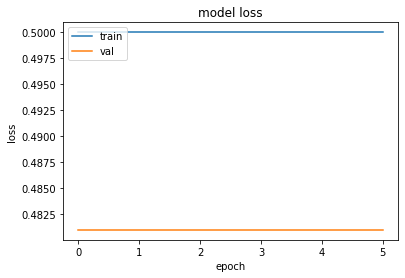

In [ ]:
experiment = 'baseline'

tds = train_prep_ds.map(vectorizefn).cache().shuffle(500, reshuffle_each_iteration=True).batch(16)
# tds = train_prep_ds.cache().shuffle(10000, reshuffle_each_iteration=True).batch(512)
vds = val_prep_ds.take(1000).map(vectorizefn).batch(512).cache()

configure_initial_weights(model, True)
# hist = train(experiment, model, tds, vds, epochs=1)
hist = train(experiment, model, tds, vds, epochs=50)

save_history(hist)
dbx_upload_history(experiment)
plot_metric(hist)

baseline_hist = hist

## nlpaugs

In [ ]:
from nltk import download as nltk_download
from nlpaug.augmenter import sentence as nas
from nlpaug.augmenter import word as naw
from nlpaug.augmenter import char as nac
from nlpaug import flow as naf

[nltk_download(item) for item in ['punkt', 'averaged_perceptron_tagger', 'wordnet']]

aug_args = dict(aug_p=0.3, aug_max=40)

chain = [
    nas.random.RandomSentAug(**aug_args),
    naw.RandomWordAug(action='delete', **aug_args),
    naw.RandomWordAug(action='swap', **aug_args),
    naw.RandomWordAug(action='crop', **aug_args),
    naw.RandomWordAug(action='substitute', **aug_args),
    nac.KeyboardAug()
]
flow = naf.Sometimes(chain, pipeline_p=0.3)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
def extract_partial(text, size):
    start = np.random.randint(0, len(text)-size-1)
    end = start + size
    return text[start:end]

def get_partial(text, size=500):
    text = text.numpy().decode("utf-8")
    text = extract_partial(text, size) if len(text) > (size + 10) else text
    return text

def handlepyfn(fn, fntype='first'):
    def callfirst(text, label):
        result_text = tf.py_function(fn, inp=[text], Tout=tf.string)
        result_text.set_shape(text.shape)
        return result_text, label
    
    switches = {
        'first': callfirst,
#         'second': callsecond,
#         'all': callall
    }
    
    return switches[fntype]

In [ ]:
# experiment = 'nlpaugs'

# # batch_size = 64 * tpu_strategy.num_replicas_in_sync

# tds = train_prep_ds.cache().shuffle(10000, reshuffle_each_iteration=True).map(randaugfn(senaug)).map(randaugfn(synaug)).batch(512)
# vds = val_prep_ds.batch(512).cache()

# configure_initial_weights(model)
# history = train(experiment, model, tds, vds, epochs=30)

# hfile = save_history(history)
# dbx_upload_history(experiment)
# plot_metric(history)

# nlpaugs = {'history': history, 'hfile': hfile}

In [ ]:
experiment = 'nlpaugs'

tds = train_prep_ds.shuffle(500, reshuffle_each_iteration=True).map(handlepyfn(get_partial)).map(nlpaugfn(flow)).map(vectorizefn).batch(16)
vds = test_prep_ds.take(1000).map(vectorizefn).batch(512).cache()

# tds = train_prep_ds.take(10).cache().shuffle(10000, reshuffle_each_iteration=True).map(randaugfn(senaug)).map(randaugfn(synaug)).batch(512)
# vds = val_prep_ds.take(10).batch(512).cache()

configure_initial_weights(model, True)
history = train(experiment, model, tds, vds, epochs=50)
# history = train(experiment, model, tds, vds, epochs=1)

hfile = save_history(history)
dbx_upload_history(experiment)
plot_metric(history)

nlpaugs = {'history': history, 'hfile': hfile}

Loading initial_weights...

Two checkpoint references resolved to different objects (<keras.layers.core.Dense object at 0x7fdcf1570d90> and <keras.layers.core.Dropout object at 0x7fdcf2db8490>).
Available weights are incompatible with the model. They will be updated.
Uploading initial_weights to remote...
Epoch 1/50
32/32 [==============================] - 79s 2s/step - loss: 0.7057 - accuracy: 0.4820 - val_loss: 0.6914 - val_accuracy: 0.5010
Epoch 2/50
32/32 [==============================] - 22s 677ms/step - loss: 0.6905 - accuracy: 0.5300 - val_loss: 0.6852 - val_accuracy: 0.5710
Epoch 3/50
32/32 [==============================] - 24s 754ms/step - loss: 0.6957 - accuracy: 0.5260 - val_loss: 0.6832 - val_accuracy: 0.5740
Epoch 4/50
32/32 [==============================] - 24s 748ms/step - loss: 0.6852 - accuracy: 0.5660 - val_loss: 0.6736 - val_accuracy: 0.6080
Epoch 5/50
32/32 [==============================] - 24s 744ms/step - loss: 0.6682 - accuracy: 0.5820 - val_loss: 0.6882 - va

In [ ]:
import numpy as np

texts = np.array(['his was an absolutely terrible', 'I have been known to fall asleep', 'As others have mentioned']).astype(np.str_)
print(texts)

seq_len = 500
vec_len = 300
batch_size = texts.shape[0]
vector = np.zeros(shape=(batch_size, seq_len, vec_len))

for tidx, doc in enumerate(nlp.pipe(texts.tolist())):
  for didx, token in enumerate(doc):
    vector[tidx][didx] = token.vector

print(vector)
# wordvecs = [[1, 2, 4, 4, 8, 1]]

# for idx in range(min(seq_len, len(wordvecs))):
#     vector[idx] = wordvecs[idx]

# print(vector)

['his was an absolutely terrible' 'I have been known to fall asleep'
 'As others have mentioned']
[[[ 1.90970004e-02  2.31189996e-01 -1.68099999e-01 ...  5.23289979e-01
    1.47510007e-01 -1.68540001e-01]
  [-4.40579988e-02  3.66109997e-01  1.80319995e-01 ...  1.86250001e-01
   -9.78169963e-02 -6.71040034e-05]
  [-1.16619999e-02  1.94830000e-01  8.88540000e-02 ... -5.46660013e-02
   -1.93399996e-01  1.39950007e-01]
  ...
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]]

 [[ 1.87329993e-01  4.05950010e-01 -5.11740029e-01 ...  1.64949998e-01
    1.87570006e-01  5.38739979e-01]
  [ 3.56700011e-02  1.85599998e-01 -3.05519998e-01 ... -2.21410006e-01
    3.82809997e-01 -3.37430015e-02]
  [ 4.12199982e-02  1.26959994e-01 -1.